In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
!pip install emoji
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

#Transformers library for BERT
!pip install transformers
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<Figure size 640x480 with 0 Axes>

In [2]:
emotion = pd.read_csv('/kaggle/input/new-emotion/emotion.csv')
emotion

Unnamed: 0                                              Input  label  \
0               0  charlie hebdo become well known for publish th...    0.0   
1               1  now 10 dead in a shooting there today retweet ...    0.0   
2               2  bbcdaniel bbcworld I am guess this is being co...    0.0   
3               3  bbcdaniel bbcworld why would you mention that ...    0.0   
4               4                 bbcdaniels bbcworld perps identify    0.0   
...           ...                                                ...    ...   
62440       62440  anonyop xplant so that mean its ok to torch an...    1.0   
62441       62441  rianalden not at all but they need to change s...    1.0   
62442       62442  xplant anonyop absoluteky but it pain I to see...    1.0   
62443       62443  xplant anonyop I am curious how many of these ...    1.0   
62444       62444  xplant anonyop you get 15000 people show up to...    1.0   

       Length Predicted_Label  
0          82             joy  
1         138             joy  
2          93           anger  
3          95             joy  
4          39            fear  
...       ...             ...  
62440      76            fear  
62441      85           anger  
62442     138         sadness  
62443     140             joy  
62444     143         sadness  

[62445 rows x 5 columns]

In [3]:
emotion.Predicted_Label.value_counts()

joy         18131
sadness     16588
anger       12578
fear        11310
love         3238
surprise      600
Name: Predicted_Label, dtype: int64

In [3]:
emotion['text'] = emotion['Input'] +" " + emotion['Predicted_Label']
emotion.text[31217]

'marcburleigh holopainenminna laracchi fear'

In [4]:
emotion.label.value_counts()

0.0    48619
1.0    13824
Name: label, dtype: int64

In [5]:
emotion[emotion.duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, Input, label, Length, Predicted_Label, text]
Index: []

In [6]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [7]:
emotion = emotion.drop_duplicates()

In [8]:
emotion.shape

(62445, 6)

In [9]:
emotion = emotion.dropna(subset=['text', 'label'])

In [10]:
emotion.label.value_counts()

0.0    48619
1.0    13824
Name: label, dtype: int64

In [11]:
#Clean emojis from text
#remove emoji
def remove_emojis(text):
    return demoji.replace(text, '')
#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])


#Then we apply all the defined functions in the following order
def deep_clean(text):
    #text = remove_emojis(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text


In [13]:
emotion.label.value_counts()

0.0    48619
1.0    13824
Name: label, dtype: int64

In [14]:
text_len = []
for t in emotion.text:
    tweet_len = len(t.split())
    text_len.append(tweet_len)

In [15]:
emotion['text_len'] = text_len

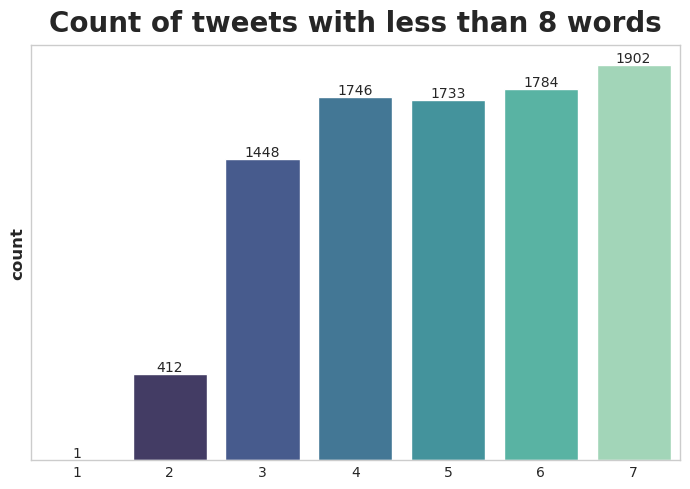

In [16]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=emotion[emotion['text_len']<8], palette='mako')
plt.title('Count of tweets with less than 8 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [17]:
emotion = emotion[emotion['text_len'] > 3]

In [18]:
emotion.sort_values(by=['text_len'], ascending=False)

Unnamed: 0                                              Input  label  \
13377       13377  france24 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _...    0.0   
57474       57474  cnnvideo dnt b rude alexdiaz dnt let his name ...    1.0   
49015       49015  rational_crisis what the fuck do the democrati...    0.0   
58719       58719  kylestrunk I am say do not release your side o...    1.0   
60133       60133  gretawire so you fuck thing he deserve to get ...    1.0   
...           ...                                                ...    ...   
10819       10819               glorioustyagi time httptcohqwvz3mfv8    0.0   
42436       42436                              amymek democrat voter    0.0   
10830       10830       elbeardsley morningedition httptco1hlaxapvzz    0.0   
33660       33660                   jeffersonobama jesuischarlie too    1.0   
35511       35511  time stopkillinginnocentpeoplefreepalestinefre...    1.0   

       Length Predicted_Label  \
13377     140            fear   
57474     136            love   
49015     138           anger   
58719     137           anger   
60133     140         sadness   
...       ...             ...   
10819      43           anger   
42436      23         sadness   
10830      51         sadness   
33660      35           anger   
35511      93         sadness   

                                                    text  text_len  
13377  france24 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _...        50  
57474  cnnvideo dnt b rude alexdiaz dnt let his name ...        35  
49015  rational_crisis what the fuck do the democrati...        34  
58719  kylestrunk I am say do not release your side o...        34  
60133  gretawire so you fuck thing he deserve to get ...        33  
...                                                  ...       ...  
10819         glorioustyagi time httptcohqwvz3mfv8 anger         4  
42436                      amymek democrat voter sadness         4  
10830  elbeardsley morningedition httptco1hlaxapvzz s...         4  
33660             jeffersonobama jesuischarlie too anger         4  
35511  time stopkillinginnocentpeoplefreepalestinefre...         4  

[60582 rows x 7 columns]

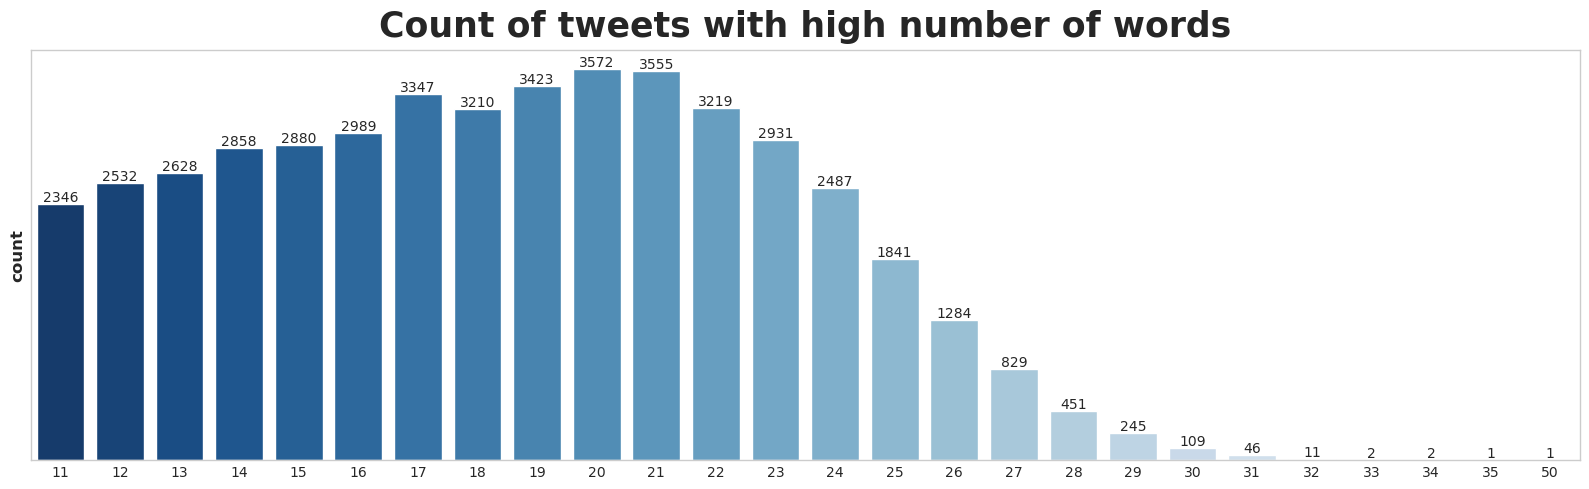

In [19]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=emotion[(emotion['text_len']<=1000) & (emotion['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [20]:
max_len = np.max(emotion['text_len'])
max_len 

50

In [21]:
emotion.sort_values(by=["text_len"], ascending=False)

Unnamed: 0                                              Input  label  \
13377       13377  france24 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _...    0.0   
57474       57474  cnnvideo dnt b rude alexdiaz dnt let his name ...    1.0   
49015       49015  rational_crisis what the fuck do the democrati...    0.0   
58719       58719  kylestrunk I am say do not release your side o...    1.0   
60133       60133  gretawire so you fuck thing he deserve to get ...    1.0   
...           ...                                                ...    ...   
10819       10819               glorioustyagi time httptcohqwvz3mfv8    0.0   
42436       42436                              amymek democrat voter    0.0   
10830       10830       elbeardsley morningedition httptco1hlaxapvzz    0.0   
33660       33660                   jeffersonobama jesuischarlie too    1.0   
35511       35511  time stopkillinginnocentpeoplefreepalestinefre...    1.0   

       Length Predicted_Label  \
13377     140            fear   
57474     136            love   
49015     138           anger   
58719     137           anger   
60133     140         sadness   
...       ...             ...   
10819      43           anger   
42436      23         sadness   
10830      51         sadness   
33660      35           anger   
35511      93         sadness   

                                                    text  text_len  
13377  france24 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _...        50  
57474  cnnvideo dnt b rude alexdiaz dnt let his name ...        35  
49015  rational_crisis what the fuck do the democrati...        34  
58719  kylestrunk I am say do not release your side o...        34  
60133  gretawire so you fuck thing he deserve to get ...        33  
...                                                  ...       ...  
10819         glorioustyagi time httptcohqwvz3mfv8 anger         4  
42436                      amymek democrat voter sadness         4  
10830  elbeardsley morningedition httptco1hlaxapvzz s...         4  
33660             jeffersonobama jesuischarlie too anger         4  
35511  time stopkillinginnocentpeoplefreepalestinefre...         4  

[60582 rows x 7 columns]

In [22]:
emotion.dtypes

Unnamed: 0           int64
Input               object
label              float64
Length               int64
Predicted_Label     object
text                object
text_len             int64
dtype: object

In [23]:
X = emotion['text']
y = emotion['label']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed_value)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [26]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[0.0000e+00, 2.9706e+04],
       [1.0000e+00, 8.4600e+03]])

In [27]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text', 'label']);

In [28]:
X_train = train_os['text'].values
y_train = train_os['label'].values

In [29]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[0.0000e+00, 2.9706e+04],
       [1.0000e+00, 2.9706e+04]])

In [30]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [31]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [32]:
nb_clf = MultinomialNB()

In [33]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [34]:
nb_pred = nb_clf.predict(X_test_tf)

In [36]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     14146
         1.0       0.65      0.88      0.75      4029

    accuracy                           0.87     18175
   macro avg       0.80      0.87      0.83     18175
weighted avg       0.89      0.87      0.87     18175



In [37]:
#we will include this in naive baiyes also to avoid confusion
category = ['rumor','not_rumor']

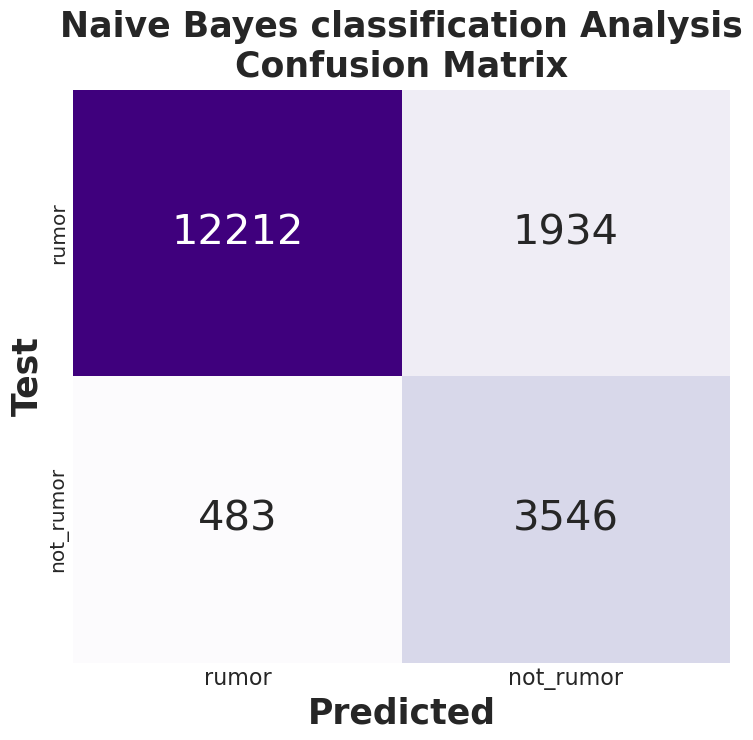

In [38]:
conf_matrix(y_test,nb_pred,'Naive Bayes classification Analysis\nConfusion Matrix', category )

In [39]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [40]:
vocabulary, tokenized_column = Tokenize(emotion["text"], max_len)

In [41]:
emotion["text"].iloc[10]

'gabtarquini bbcdaniel bbcworld cossette a broadcast journalist with europe1 news hope that help mate from httptcodop4ubrbsr joy'

In [42]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,  3238,  1419,   284,
       21301,     7,  2224,   318,    32,  5240,   167,   228,    17,
         300,  1438,    59, 21302,     2])

In [43]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

In [44]:
keys

['the',
 'joy',
 'to',
 'is',
 'sadness',
 'not',
 'a',
 'of',
 'you',
 'I',
 'anger',
 'in',
 'fear',
 'and',
 'do',
 'it',
 'that',
 'they',
 'have',
 'are']

In [45]:
values

[27470,
 17876,
 17220,
 17076,
 15941,
 15216,
 14000,
 13711,
 13445,
 12793,
 12135,
 12122,
 11258,
 11035,
 10416,
 9625,
 9020,
 8920,
 7658,
 7525]

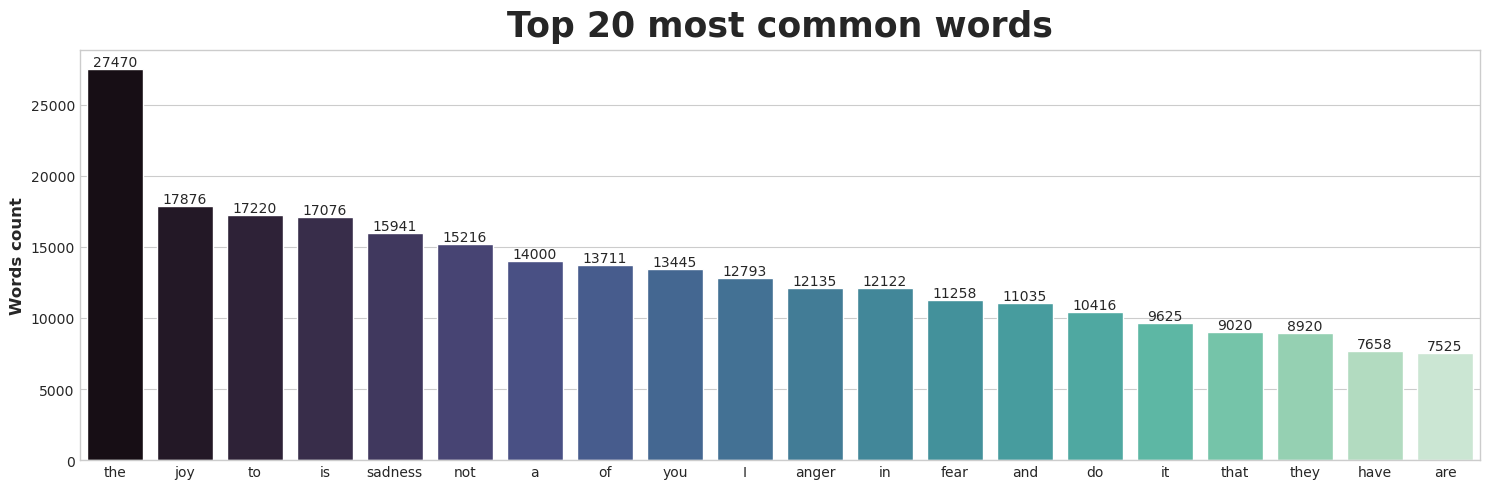

In [46]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys,y=values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

In [47]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [48]:
EMBEDDING_DIM = 200

In [49]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [50]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 59181


In [51]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [52]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (59181, 200)


In [53]:
X = tokenized_column
y = emotion['label'].values

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed_value)

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [56]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[0.0000e+00, 2.9706e+04],
       [1.0000e+00, 8.4600e+03]])

In [57]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [58]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[0.0000e+00, 2.9706e+04],
       [1.0000e+00, 2.9706e+04]])

In [59]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [60]:
BATCH_SIZE = 32

In [61]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [69]:
NUM_CLASSES = 2 #We are dealing with a multiclass classification of 2 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 0.001 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 25 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [71]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [72]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(59181, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [73]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

In [74]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 25
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        labels = labels.type(torch.LongTensor)
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)
            labels = labels.type(torch.LongTensor)
            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 91.927083).  Saving model ...
	Train_loss : 0.2708 Val_loss : 0.2097
	Train_acc : 87.242% Val_acc : 91.927%
Epoch 2:Validation accuracy did not increase
	Train_loss : 0.0643 Val_loss : 0.2277
	Train_acc : 97.692% Val_acc : 91.359%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.0314 Val_loss : 0.2968
	Train_acc : 98.848% Val_acc : 91.051%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0188 Val_loss : 0.4007
	Train_acc : 99.305% Val_acc : 90.909%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0113 Val_loss : 0.4807
	Train_acc : 99.606% Val_acc : 90.720%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0088 Val_loss : 0.4765
	Train_acc : 99.680% Val_acc : 90.696%
Epoch 7:Validation accuracy did not increase
	Train_loss : 0.0055 Val_loss : 0.5465
	Train_acc : 99.791% Val_acc : 90.483%
Epoch 8:Validation accuracy did not increase
	Train_loss : 0.0044 Val_loss : 0.5391
	Train_acc : 99.83

In [75]:
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [76]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [77]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=category))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

       rumor       0.95      0.94      0.95     14122
   not_rumor       0.80      0.83      0.81      4022

    accuracy                           0.92     18144
   macro avg       0.87      0.88      0.88     18144
weighted avg       0.92      0.92      0.92     18144



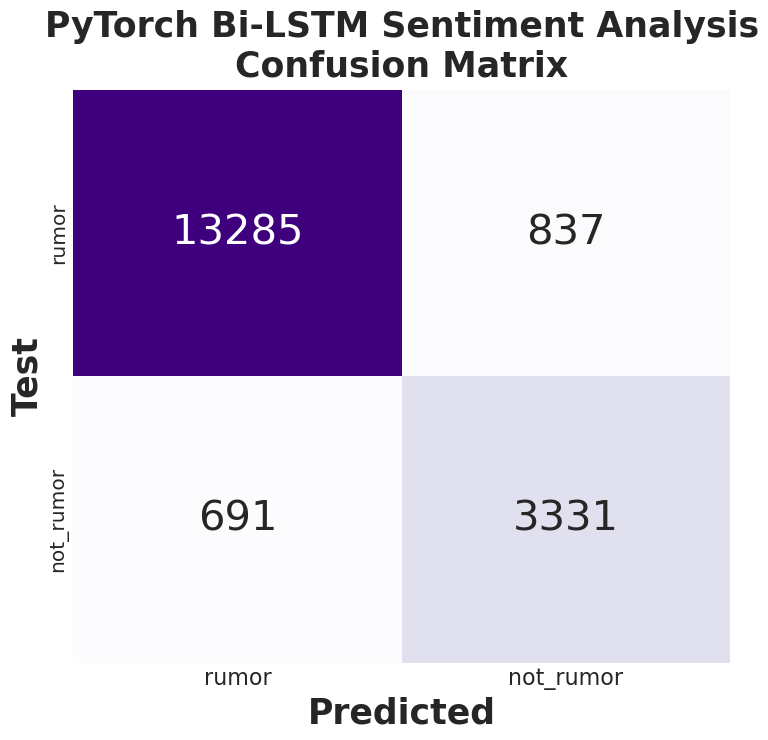

In [78]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', category)

In [24]:
X = emotion['text'].values
y = emotion['label'].values

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed_value)

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [27]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [28]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [29]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[0.0000e+00, 2.9706e+04],
       [1.0000e+00, 2.9706e+04]])

In [30]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [31]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [32]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  61


In [33]:
MAX_LEN = 60

In [34]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [35]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

In [36]:
batch_size = 32

In [37]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [38]:
%%time
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 2
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add dense layers to perform the classification
        self.classifier = nn.Sequential(
            nn.Linear(n_input,  n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
        # Add possibility to freeze the BERT model
        # to avoid fine tuning BERT params (usually leads to worse results)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input data to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        type(logits)
        return logits



CPU times: user 57 µs, sys: 0 ns, total: 57 µs
Wall time: 61.5 µs


In [39]:

def initialize_model(epochs=10):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)
    
    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )
    
    ### Set up learning rate scheduler ###

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Defint the scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=30

In [41]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 

In [42]:
# Define Cross entropy Loss function for the multiclass classification task
from sklearn.metrics import classification_report
val_preds = []
val_true_labels = []

bestst_val_accuracy = 0.0
best_epoch = -1

loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    global best_val_accuracy  # Declare best_val_accuracy as a global variable
    best_val_accuracy = 0.0 
    global best_epoch
    best_epoch = -1
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            b_labels = b_labels.type(torch.LongTensor)
            #logits = logits.type(torch.LongTensor)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)
            batch_labels = batch_labels.type(torch.LongTensor)
            loss = loss_fn(logits, batch_labels)


            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()
            val_preds.extend(preds.cpu().numpy())
            val_true_labels.extend(batch_labels.cpu().numpy())

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        # ...
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch_i + 1
# ...

        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [ ]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.612956   |  888.27  
   200    |   0.498534   |  877.29  
   300    |   0.438833   |  880.25  
   400    |   0.377991   |  881.60  
   500    |   0.350226   |  882.52  
   600    |   0.306684   |  879.84  
   700    |   0.293329   |  880.93  
   800    |   0.286234   |  880.95  
   900    |   0.255511   |  880.95  
  1000    |   0.256460   |  884.24  
  1100    |   0.236700   |  882.76  
  1200    |   0.213937   |  880.85  
  1300    |   0.198725   |  883.31  
  1400    |   0.224443   |  884.91  
  1500    |   0.198403   |  881.96  
  1600    |   0.183021   |  882.74  
  1700    |   0.182168   |  888.24  
  1800    |   0.183723   |  883.02  
  1856    |   0.170627   |  491.32  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
------

In [ ]:
# Calculate classification report for the best epoch
print("Best Epoch:", best_epoch)
print("Best Validation Accuracy:", best_val_accuracy)

classification_rep = classification_report(val_true_labels, val_preds)
print("\nClassification Report for Best Epoch:\n")
print(classification_rep)


In [41]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            b_labels = b_labels.type(torch.LongTensor)
            #logits = logits.type(torch.LongTensor)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)
            batch_labels = batch_labels.type(torch.LongTensor)
            loss = loss_fn(logits, batch_labels)


            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [ ]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.609052   |  663.18  
   200    |   0.484862   |  652.74  
   300    |   0.433438   |  653.92  
   400    |   0.375797   |  662.30  
   500    |   0.339777   |  657.94  
   600    |   0.298725   |  654.74  
   700    |   0.284953   |  654.97  
   800    |   0.280043   |  660.89  
   900    |   0.259473   |  656.71  
  1000    |   0.259122   |  652.43  
  1100    |   0.240318   |  654.43  
  1200    |   0.213309   |  655.55  
  1300    |   0.206401   |  663.76  
  1400    |   0.215680   |  660.69  
  1500    |   0.211225   |  661.19  
  1600    |   0.188455   |  677.48  
  1700    |   0.190846   |  665.87  
  1800    |   0.186727   |  659.73  
  1856    |   0.179407   |  372.35  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
------